# Leitura, Análise e Pré-Processamento

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd

df = pd.read_csv('data/drug_consumption_prepared.csv', index_col='ID')
df.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
ID,,,,,,,,,,,,,,,,,,,,,
1,35 - 44,Female,Professional Certificate/Diploma,UK,Mixed-White/Asian,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Used in Last Decade,Never Used,Never Used
2,25 - 34,Male,Doctorate Degree,UK,White,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,Used in Last Month,Never Used,Used in Last Decade,Never Used,Used in Last Decade,Used in Last Year,Never Used,Used in Last Month,Never Used,Never Used
3,35 - 44,Male,Professional Certificate/Diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used,Never Used
4,18 - 24,Female,Masters Degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,Never Used,Never Used,Used in Last Decade,Never Used,Never Used,Never Used,Never Used,Used in Last Decade,Never Used,Never Used
5,35 - 44,Female,Doctorate Degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,Used over a Decade Ago,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used,Used in Last Decade,Used in Last Decade,Never Used,Never Used


O dataset possui 12 colunas de características, sendo 5 colunas categóricas e 7 colunas numéricas. As 5 colunas categóricas referem-se a faixa etária, gênero, nível de escolaridade, país de residência e etnia. As 7 colunas numéricas são indicadores comportamentais e de personalidade, que incluem neuroticismo, extroversão, abertura à experiência, agradabilidade, conscienciosidade, impulsividade e busca de sensações. Além disso, o dataset inclui 18 colunas adicionais relacionadas ao uso de drogas, que podem ser utilizadas como target para problemas de classificação.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1885 entries, 1 to 1888
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                1885 non-null   object 
 1   Gender             1885 non-null   object 
 2   Education          1885 non-null   object 
 3   Country            1885 non-null   object 
 4   Ethnicity          1885 non-null   object 
 5   Neuroticism        1885 non-null   float64
 6   Extraversion       1885 non-null   float64
 7   Openness           1885 non-null   float64
 8   Agreeableness      1885 non-null   float64
 9   Conscientiousness  1885 non-null   float64
 10  Impulsiveness      1885 non-null   float64
 11  Sensationness      1885 non-null   float64
 12  Alcohol            1885 non-null   object 
 13  Amphet             1885 non-null   object 
 14  Amyl               1885 non-null   object 
 15  Benzos             1885 non-null   object 
 16  Caff               1885 non-n

## Target - Colunas das substâncias

Durante a coleta dos dados, foi inserida uma droga fictícia (Semer) com o objetivo de identificar usuários que possam estar mentindo ou exagerando em suas respostas. Portanto, é prudente que esses usuários sejam excluídos da análise e que essa droga seja removida do dataset.

In [4]:
df = df[df['Semer'] == 'Never Used'].drop('Semer', axis=1)

Cada uma das 18 colunas relacionadas ao uso de drogas possui 7 possíveis valores que indicam qual foi a última vez que a substância foi utilizada. Nesse caso, mapeamos cada valor para um domínio discreto em que a distância de tempo é mantida.

É um range de [0, 6] que representa, respectivamente:
- (0) "nunca";
- (1) "há mais de uma década";
- (2) "na última década";
- (3) "no último ano";
- (4) "no último mês";
- (5) "na última semana";
- (6) "no dia anterior".

In [5]:
def drug_usage_map(array):
    labels = [
        'Never Used',
        'Used over a Decade Ago',
        'Used in Last Decade',
        'Used in Last Year',
        'Used in Last Month',
        'Used in Last Week',
        'Used in Last Day'
    ]
    return list(map(labels.index, array))

drug_columns = df.loc[:, 'Alcohol':].columns.tolist()
df[drug_columns] = df[drug_columns].apply(drug_usage_map)

Para simplificar as análises, vamos agrupar temporariamente esses valores em duas categorias:

- (0) Usou há muito tempo ou nunca usou (0, 1, 2);
- (1) Usou recentemente (3, 4, 5, 6).

In [6]:
import numpy as np

# salvando para restaurar os valores após análise
original_labels = df[drug_columns]
df[drug_columns] = df[drug_columns].apply(lambda x: np.where(x > 2, 1, 0))

Plotando a porcentagem de usuários de cada droga com base no total de usuários.

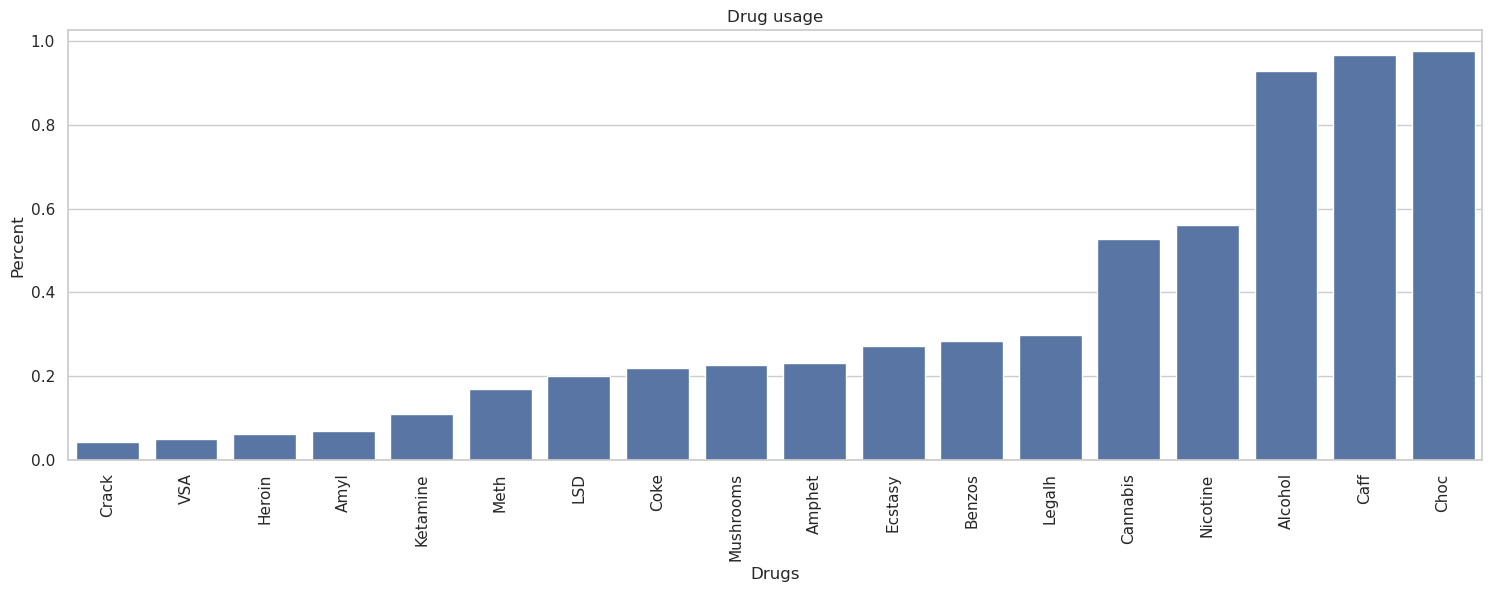

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(15, 5), sharey=True)
fig.tight_layout()

usage_percent = (df[drug_columns].sum() / len(df)).sort_values()
sns.barplot(x=usage_percent.index, y=usage_percent.values, ax=ax)
ax.set_xlabel('Drugs'); ax.set_ylabel('Percent')
ax.tick_params(axis='x', rotation=90)
ax.set_title('Drug usage')
pass

Plotando a correlação entre o uso das drogas.

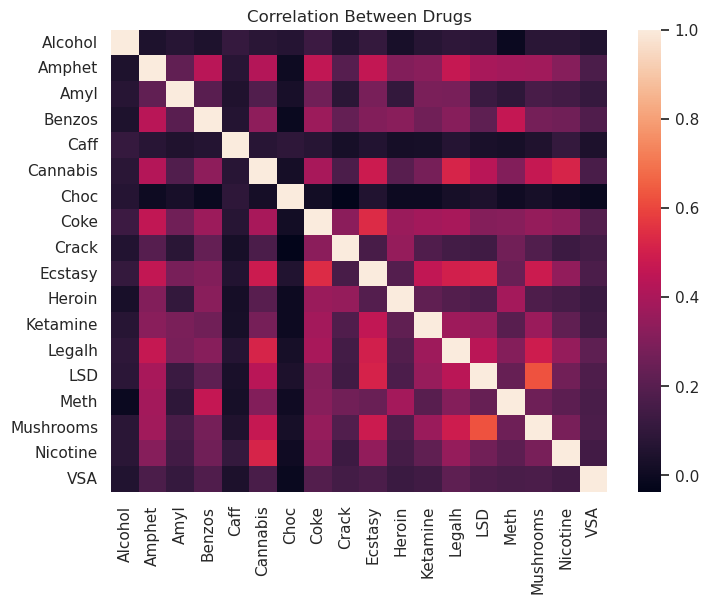

In [8]:
corr_matrix = df.loc[:, drug_columns].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, ax=ax)
ax.set_title('Correlation Between Drugs')
pass

É evidenciada uma correlação significativa entre **LSD** e **Mushrooms**, o que pode ser resultado da natureza alucinógena dessas drogas.

## Características Categóricas

Definindo funções para visualização das características categóricas.

In [9]:
def plot_distribution_cat(data, column):
    fig, ax = plt.subplots()
    value_counts = data[column].value_counts() / len(data)
    patches, _ = ax.pie(value_counts.values, radius=1)

    labels = [f'{i} - {j:1.2f} %' for i,j in zip(value_counts.index, value_counts.values)]
    ax.set_xlabel(column)
    ax.legend(patches, labels, fontsize=8, bbox_to_anchor=(1, 0.5))

    fig.suptitle('Data Distribution')
    fig.tight_layout()

def plot_drug_usage_cat(data, column):
    n_rows, n_cols = 3, 6
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharex=True, sharey=True)
    
    for i, (ax, drug_column) in enumerate(zip(axs.flatten(), drug_columns)):
        sns.barplot(data, x=column, y=drug_column, ax=ax, order=sorted(data[column].unique()))
        ax.set_title(drug_column)
        ax.set_xlabel(''); ax.set_ylabel('')

        is_last_row = int(i // n_cols) == (n_rows - 1)
        if is_last_row: ax.set_xlabel(column)

        is_first_col = (i % n_cols) == 0
        if is_first_col: ax.set_ylabel('Usage Percent')
        ax.tick_params(axis='x', rotation=90)

    fig.suptitle(f'Drug usage by {column.lower()}')
    fig.tight_layout()
    plt.show()

### Faixa etária - "Age"

Essa característica representa a faixa de idade do indivíduo, ela assume 6 possíveis valores:

- 18 - 24
- 25 - 34
- 35 - 44
- 45 - 54
- 55 - 64
- 65+

Posteriormente, esses valores são mapeados para valores discretos, mantendo a ordem entre eles.

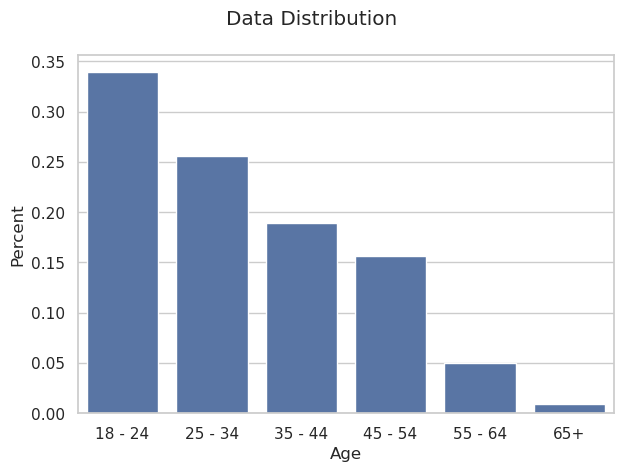

In [10]:
fig, ax = plt.subplots()

value_counts = (df['Age'].value_counts() / len(df))
sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax)
ax.set_ylabel('Percent')

fig.suptitle('Data Distribution')
fig.tight_layout()

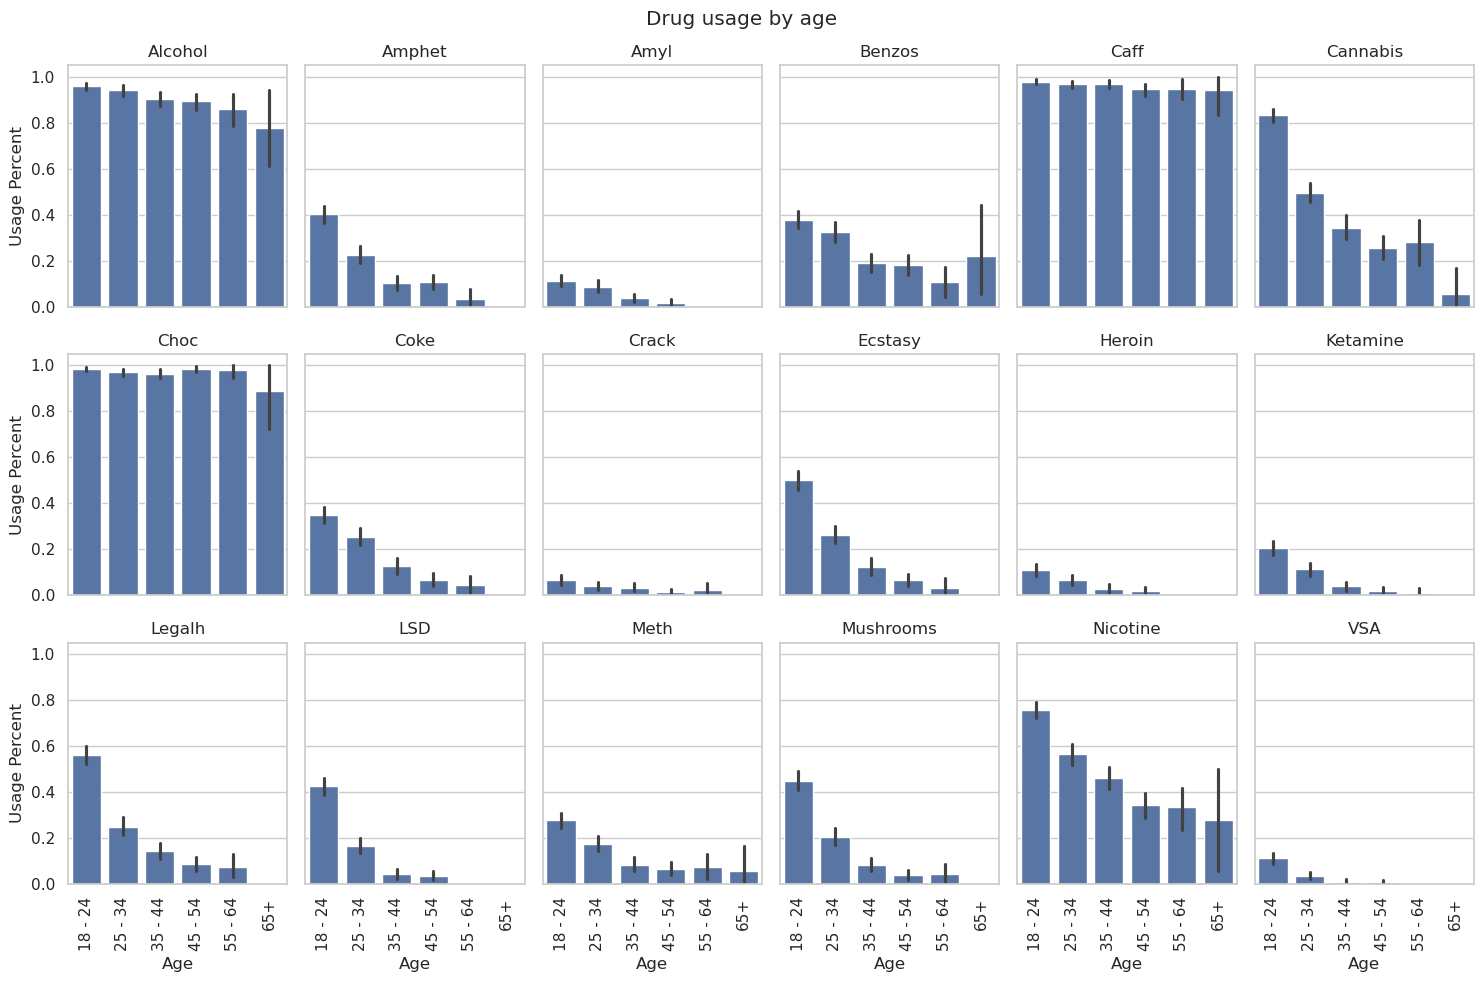

In [11]:
plot_drug_usage_cat(df, 'Age')

**Alcohol**, **Caff** e **Choc** parecem manter uma alta taxa de uso em todas as idades. **Cannabis** apresentou um uso acentuado na faixa de idade mais jovem (**18-24**) em comparação com as demais, enquanto **Benzos** apresentou um uso considerável em faixas de idade mais avançadas.

### Gênero - "Gender"

Essa característica representa o gênero do indivíduo, ela assume 2 possíveis valores, Masculino e Feminino.

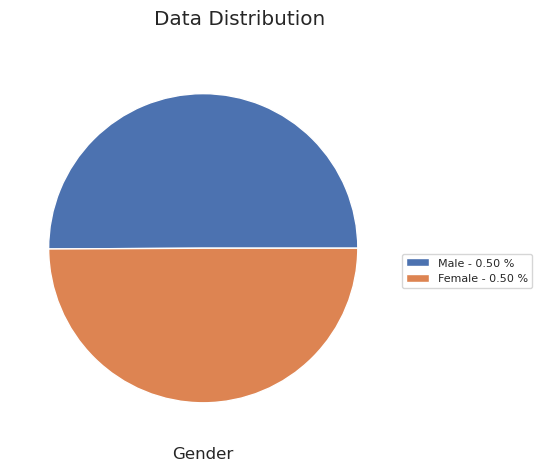

In [12]:
plot_distribution_cat(df, 'Gender')

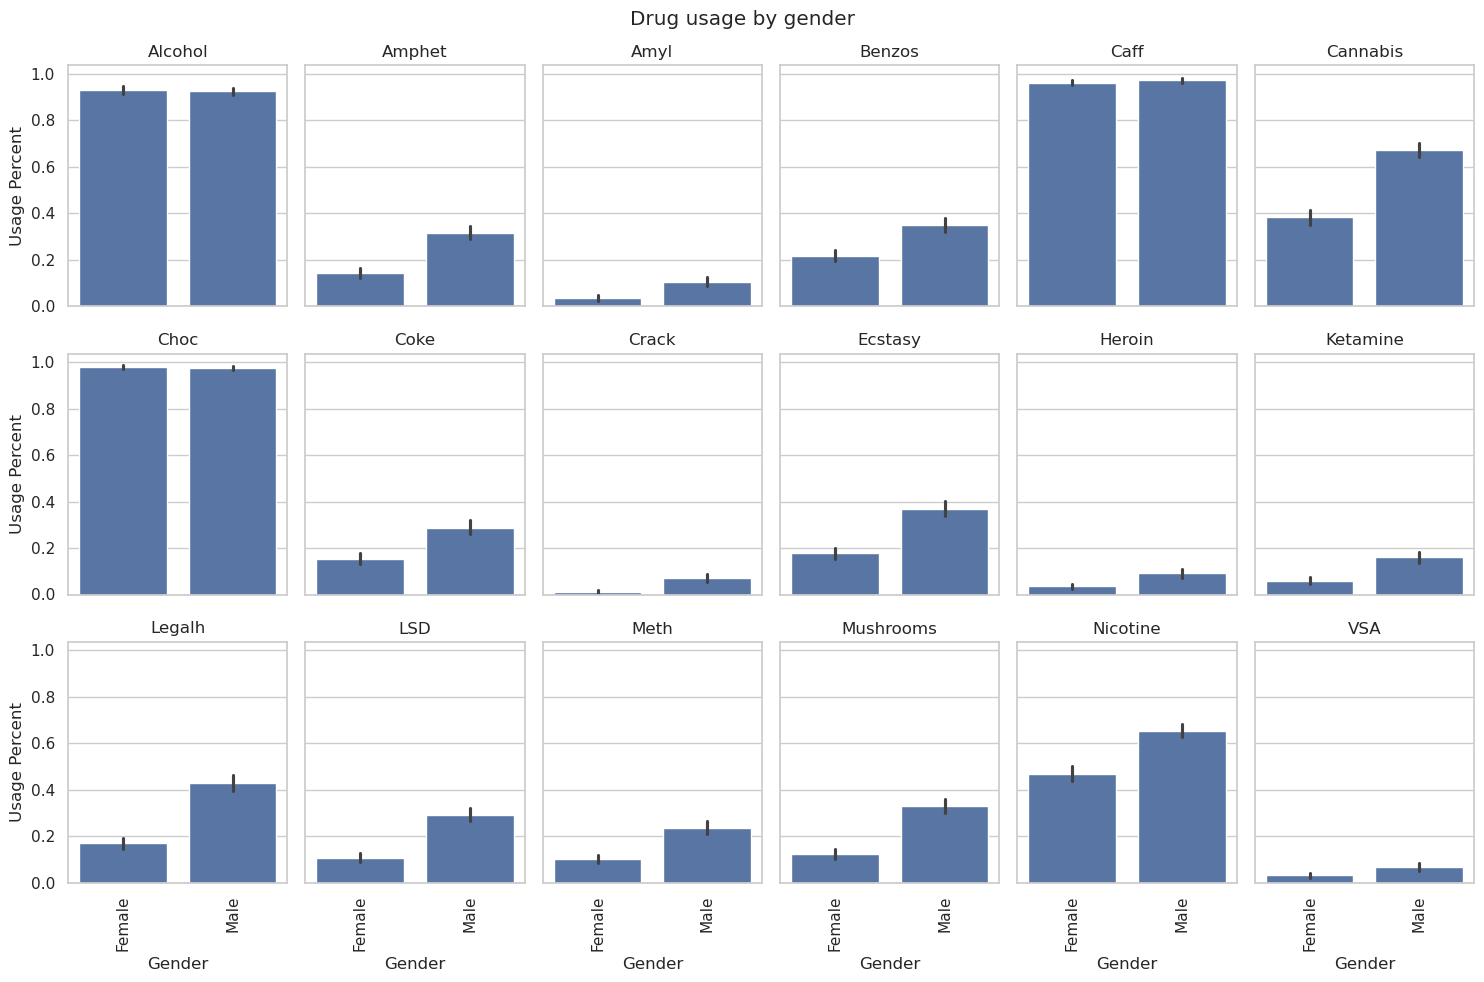

In [13]:
plot_drug_usage_cat(df, 'Gender')

No geral os homens apresentaram uma taxa de consumo maior, em comparação com as mulheres.

### Escolaridade - "Education"

Essa característica representa o nível de escolaridade do indivíduo, originalmente ela possuia 9 possíveis valores, para simplificar, vamos agrupar esses valores em duas categorias:

- No Certificate Or Degree (0);
- Professional Certificate/Diploma (1).

In [14]:
def education_map(array):
    dict_map = {
        **dict.fromkeys([
            'Left School Before 16 years', 'Left School at 16 years',
            'Left School at 17 years', 'Left School at 18 years',
            'Some College, No Certificate Or Degree'
        ], 'No Certificate\nOr Degree'),
        **dict.fromkeys([
            'Professional Certificate/Diploma',
            'University Degree', 'Masters Degree',
            'Doctorate Degree'
        ], 'Professional\nCertificate/Diploma')
    }
    return list(map(lambda x: dict_map[x], array))

df[['Education']] = df[['Education']].apply(education_map)

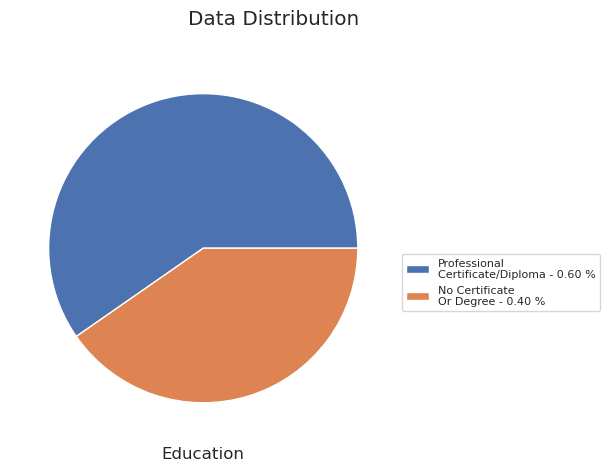

In [15]:
plot_distribution_cat(df, 'Education')

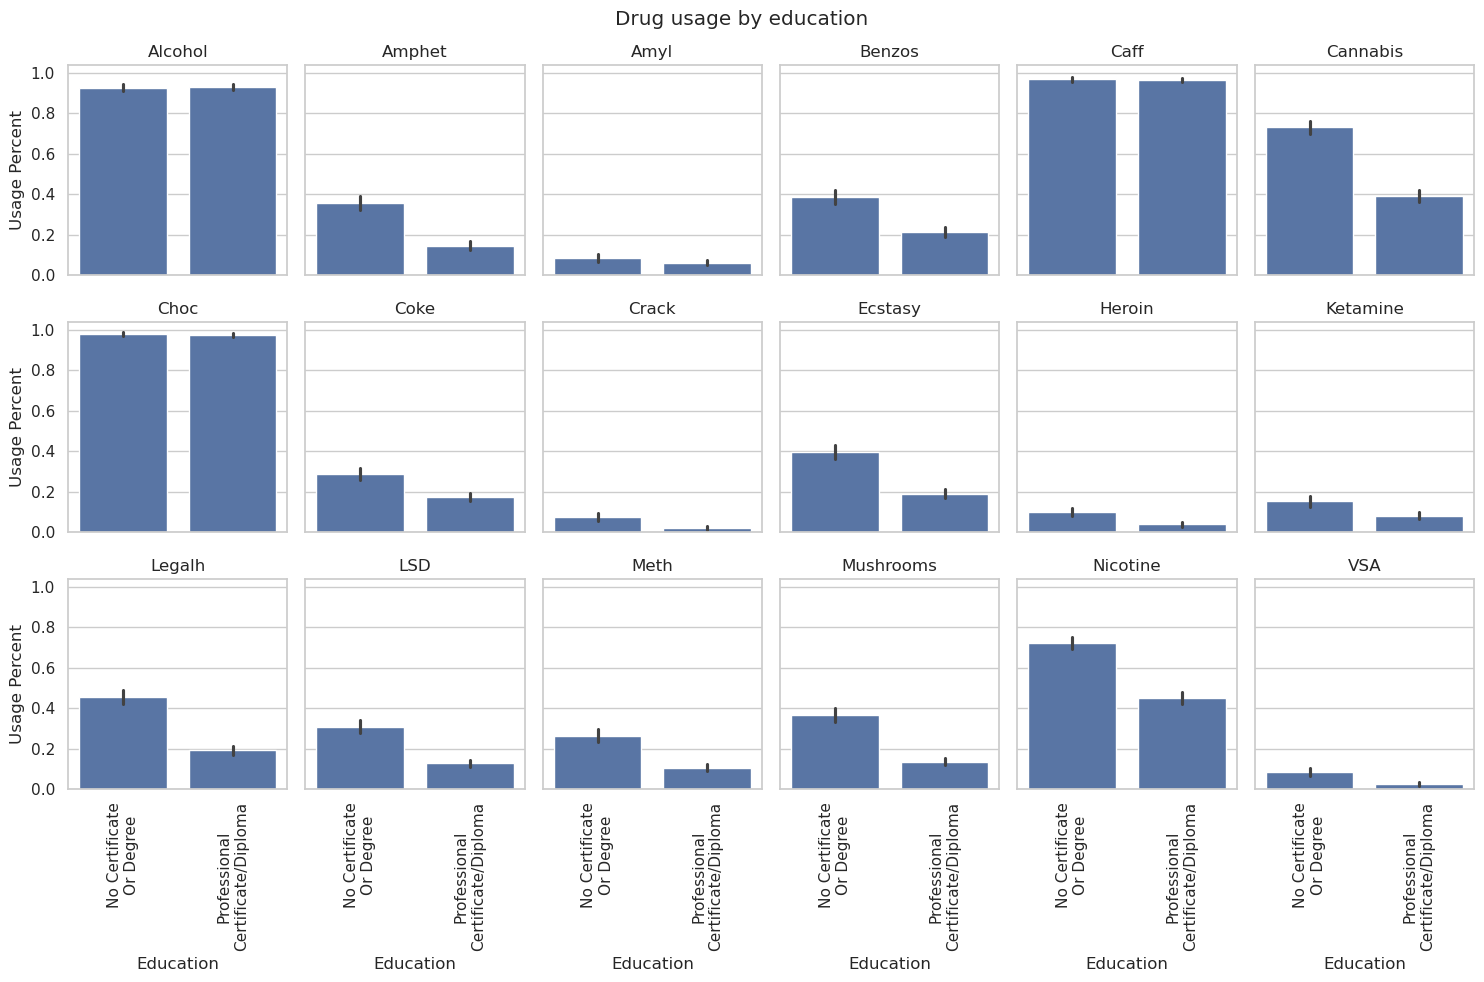

In [16]:
plot_drug_usage_cat(df, 'Education')

No geral quem não possui um diploma apresentou taxas maiores de consumo, porém não se pode dizer que essa é a causa, dado que isso pode ter correlação com a faixa de idade do indivíduo, e outras **N** variáveis.

### País - "Country"

Essa característica representa o país de origem do indivíduo, ela assume 7 possíveis valores. No entanto, **USA** e **UK** representam 85% dos dados, como é possível ver abaixo. Portanto, acredita-se que não vale seu uso.

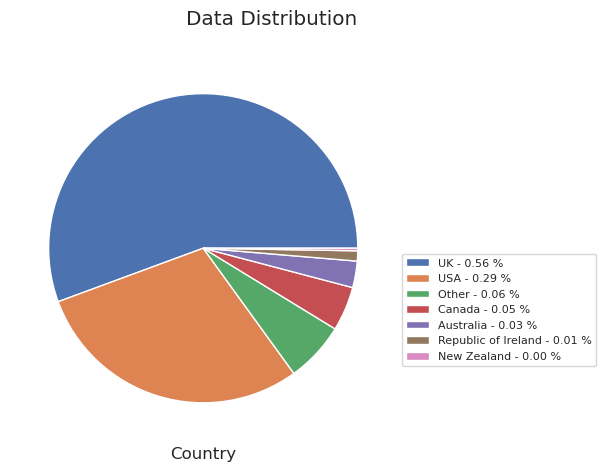

In [17]:
plot_distribution_cat(df, 'Country')

In [18]:
df = df.drop('Country', axis=1)

### Etnia - "Ethnicity"

Essa característica representa a etnia do indivíduo, ela assume 7 possíveis valores. No entanto, assim como na característica **Country**, temos uma categoria que representa 90% dos dados. Portanto, acredita-se também que não vale seu uso.

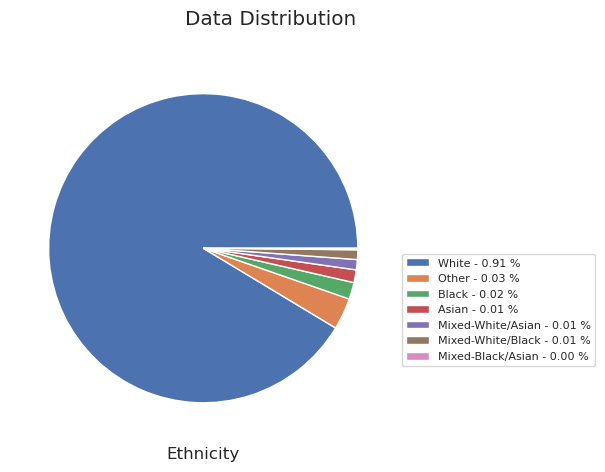

In [19]:
plot_distribution_cat(df, 'Ethnicity')

In [20]:
df = df.drop('Ethnicity', axis=1)

## Características Numéricas

Definindo funções para visualização das características numéricas.

In [21]:
def plot_distribution_num(data, column):
    fig, ax = plt.subplots()

    sns.histplot(x=data[column], stat='percent', kde=True, ax=ax)
    fig.suptitle('Data Distribution')
    fig.tight_layout()

def plot_drug_usage_num(data, column):
    n_rows, n_cols = 3, 6
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharex=True, sharey=True)
    
    for i, (ax, drug_column) in enumerate(zip(axs.flatten(), drug_columns)):
        sns.histplot(data=data, x=column, hue=drug_column, stat='percent', kde=True, ax=ax)
        ax.set_title(drug_column)
        ax.set_xlabel(''); ax.set_ylabel('')

        is_last_row = int(i // n_cols) == (n_rows - 1)
        if is_last_row: ax.set_xlabel(column)

        is_first_col = (i % n_cols) == 0
        if is_first_col: ax.set_ylabel('Percent')
        ax.tick_params(axis='x', rotation=90)

    fig.suptitle(f'Drug usage by {column.lower()}')
    fig.tight_layout()
    plt.show()

### Neuroticismo - "Neuroticism"

Essa medida refere-se à tendência de uma pessoa em experimentar emoções negativas, como ansiedade, medo, tristeza e irritabilidade. Pessoas altamente neuroticas tendem a ser mais suscetíveis ao estresse e podem reagir de maneira exagerada a situações cotidianas.

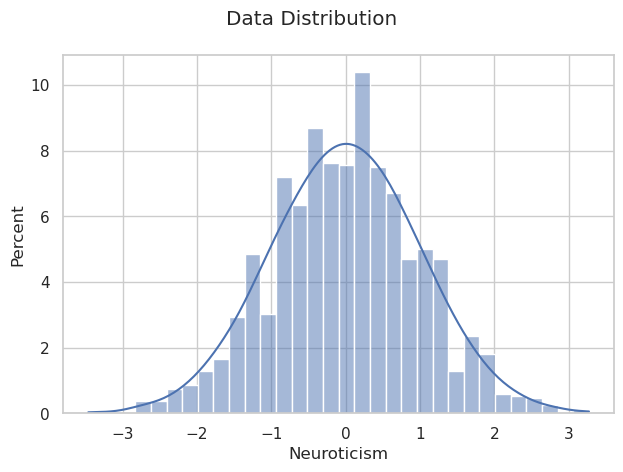

In [22]:
plot_distribution_num(df, 'Neuroticism')

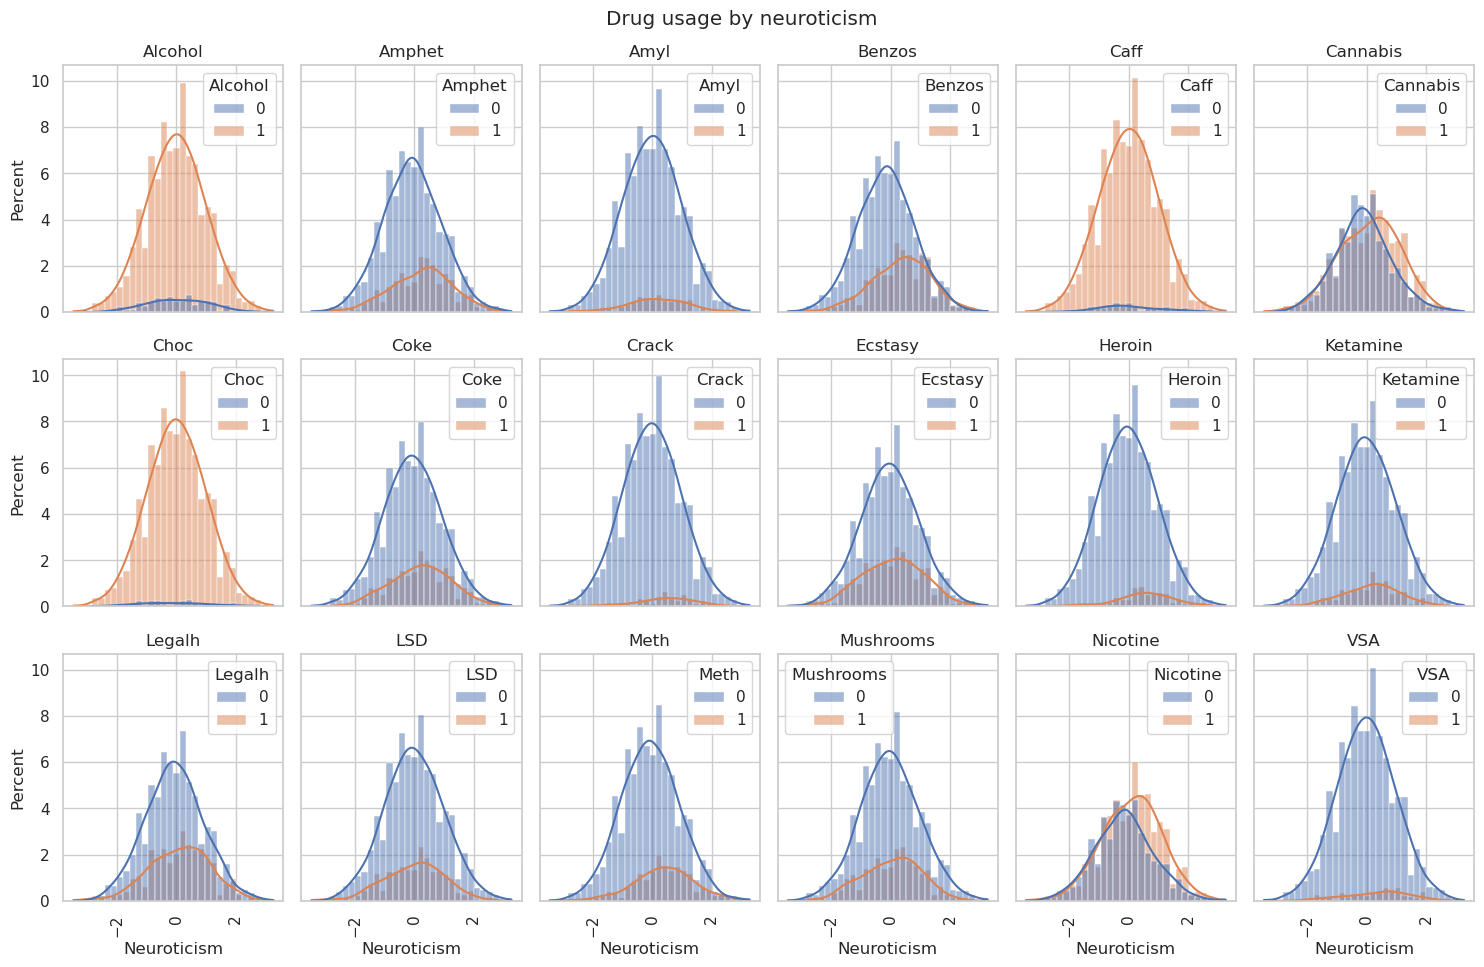

In [23]:
plot_drug_usage_num(df, 'Neuroticism')

Com a exceção de **Alcohol**, **Caff** e **Choc**, é perceptível que para as demais substâncias, uma parte dos usuários apresenta uma leve propensão ao neuroticismo, apesar da grande sobreposição.

### Extroversão - "Extraversion"

Essa medida reflete o quanto uma pessoa é sociável, energética e propensa a buscar estimulação do ambiente externo. Indivíduos extrovertidos tendem a ser assertivos, entusiasmados e se sentem à vontade em situações sociais.

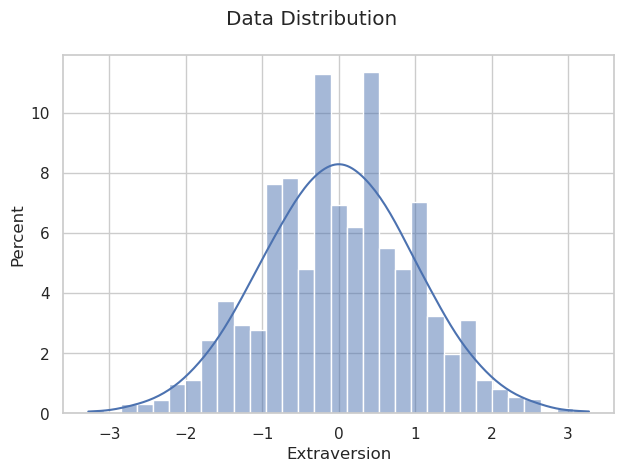

In [24]:
plot_distribution_num(df, 'Extraversion')

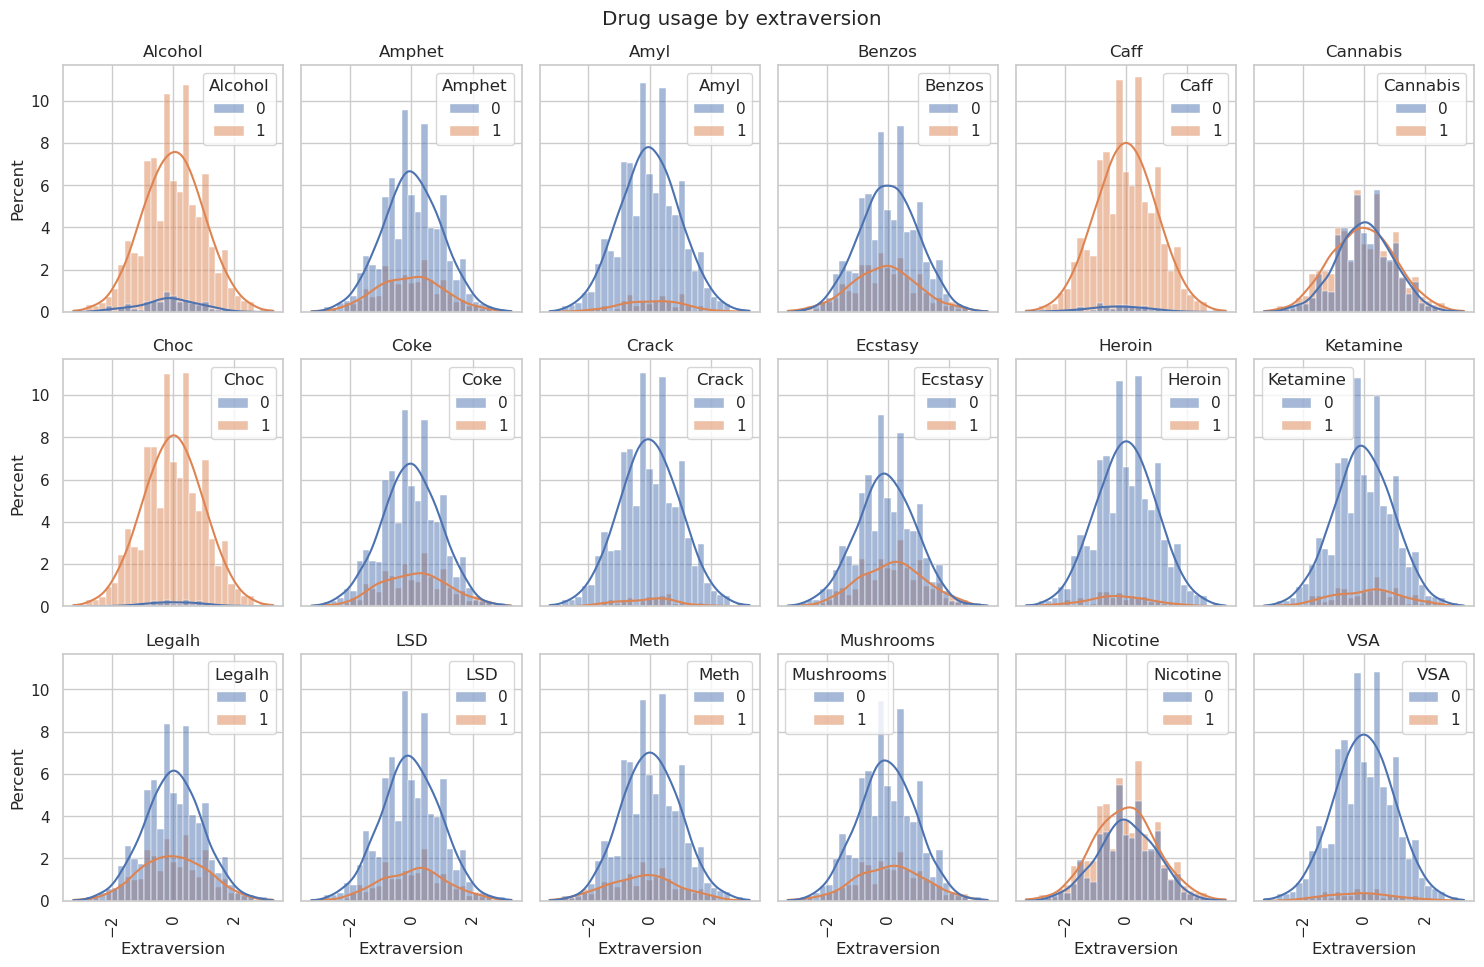

In [25]:
plot_drug_usage_num(df, 'Extraversion')

Ao contrário da medida anterior, nessa não é possível enxergar um padrão muito claro.

### Abertura à experiência - "Openness"

Essa medida indica o quão aberto uma pessoa é a novas ideias, experiências e maneiras de pensar. Pessoas com alta abertura à experiência são curiosas, imaginativas e tendem a ter uma ampla gama de interesses.

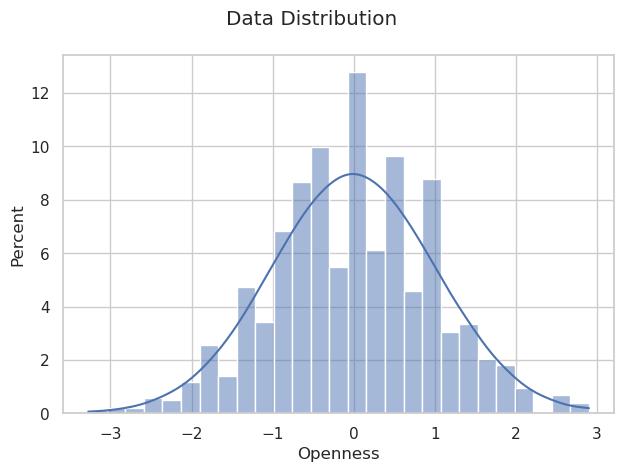

In [26]:
plot_distribution_num(df, 'Openness')

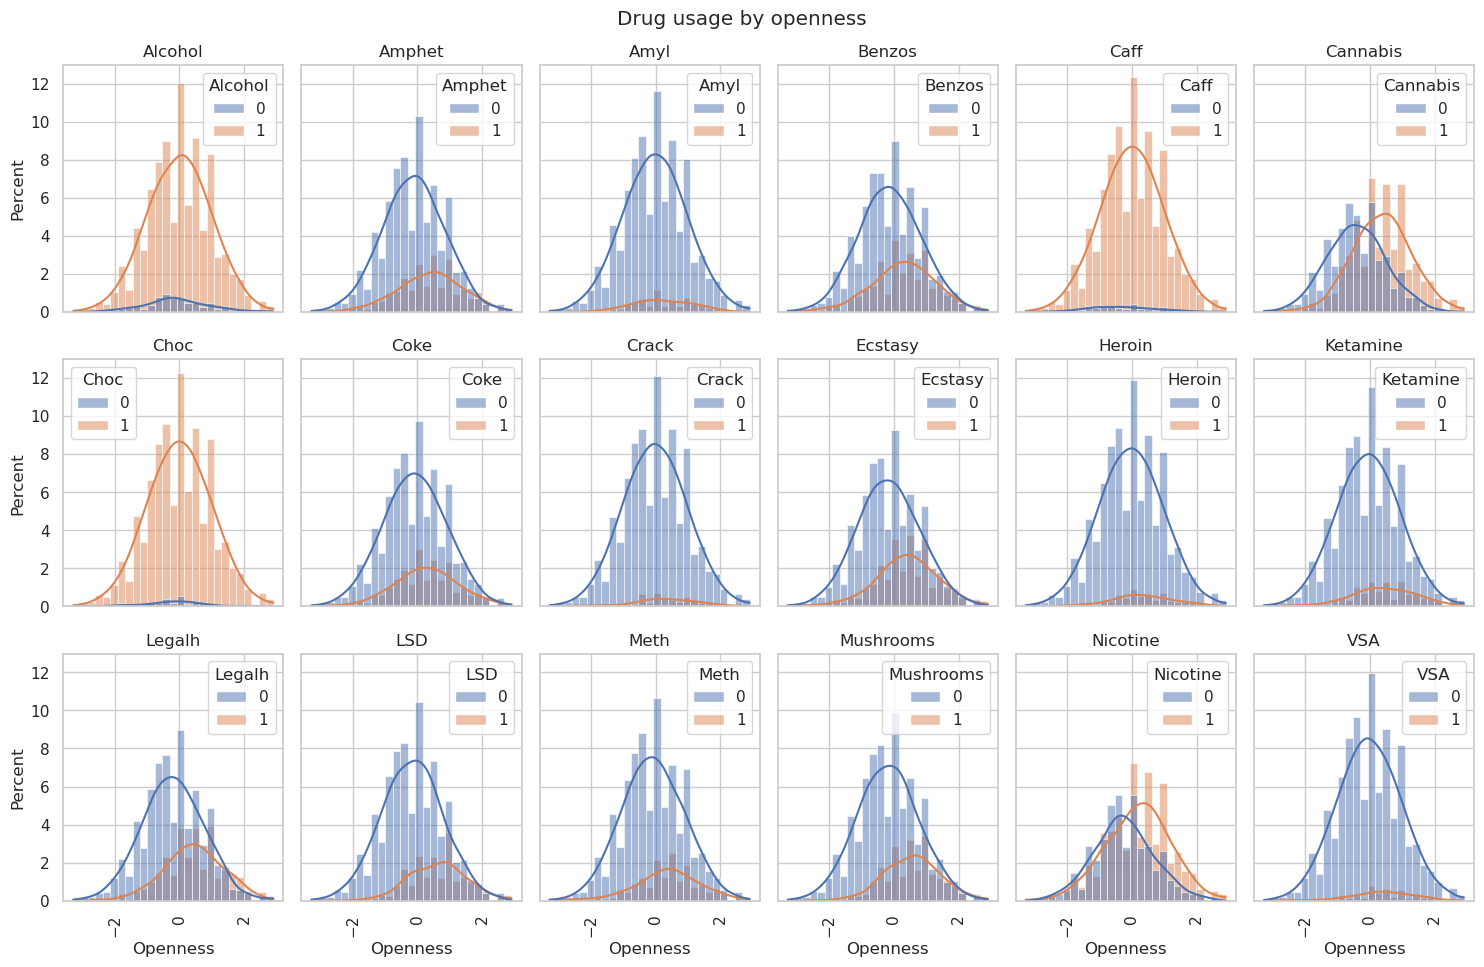

In [27]:
plot_drug_usage_num(df, 'Openness')

Aqui temos uma conclusão semelhante a da primeira medida, principalmente para usuários de **Cannabis**.

### Agradabilidade - "Agreeableness"

Essa medida refere-se à disposição de uma pessoa para cooperar e ser útil aos outros. Pessoas altamente agradáveis são altruístas, simpáticas e confiantes nas relações interpessoais.

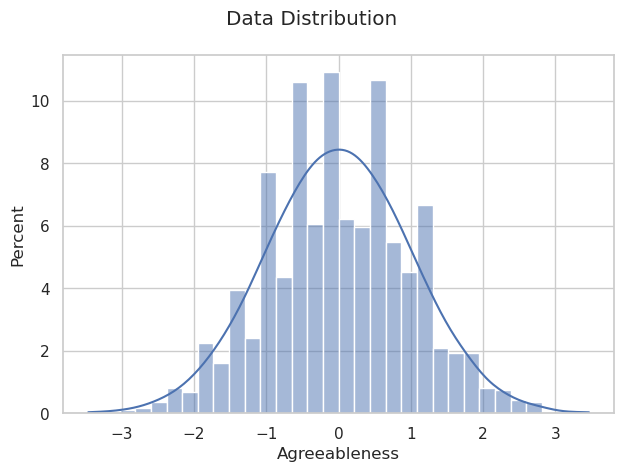

In [28]:
plot_distribution_num(df, 'Agreeableness')

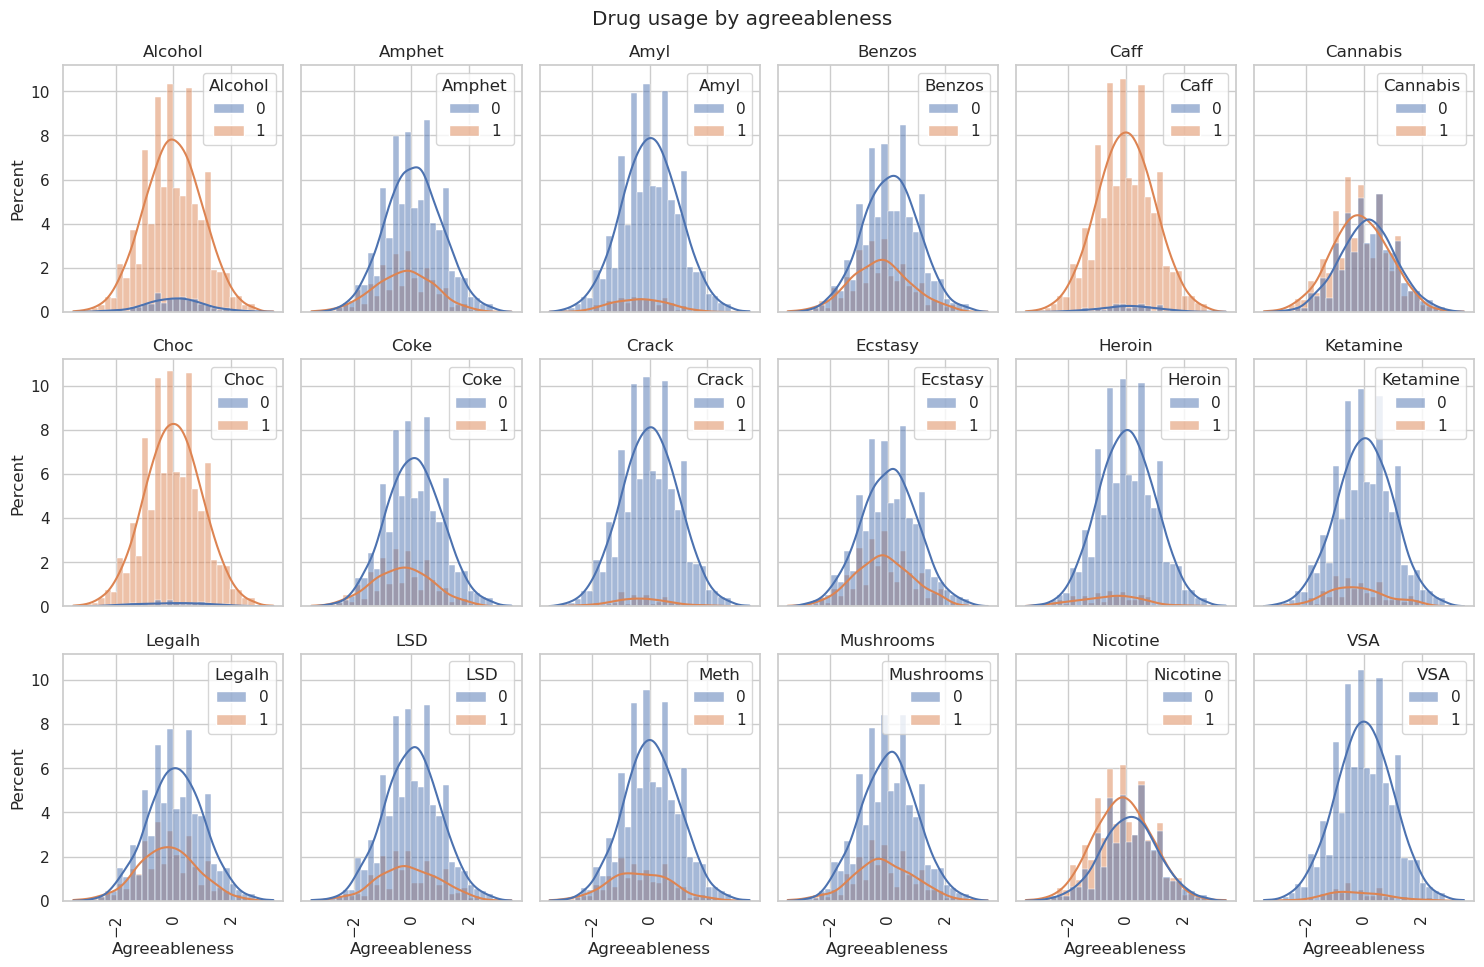

In [29]:
plot_drug_usage_num(df, 'Agreeableness')

Nesse caso, parece que os usuários das substâncias apresentaram uma menor agradabilidade, mas novamente com bastante sobreposição.

### Conscienciosidade - "Conscientiousness"

Essa medida indica o grau de organização, persistência, controle e motivação de uma pessoa para atingir metas. Pessoas conscientes são disciplinadas, eficientes e orientadas para o cumprimento de deveres.

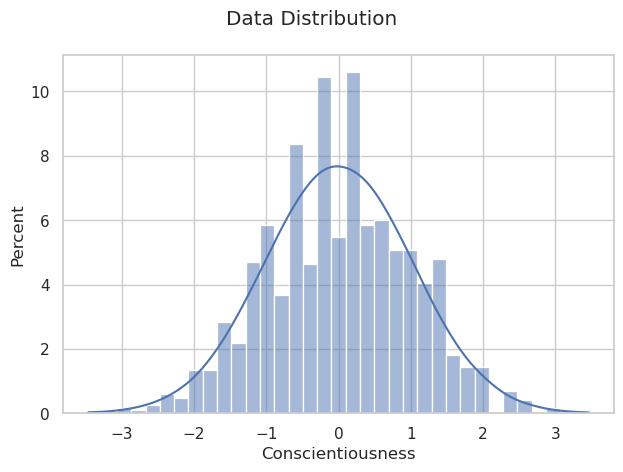

In [30]:
plot_distribution_num(df, 'Conscientiousness')

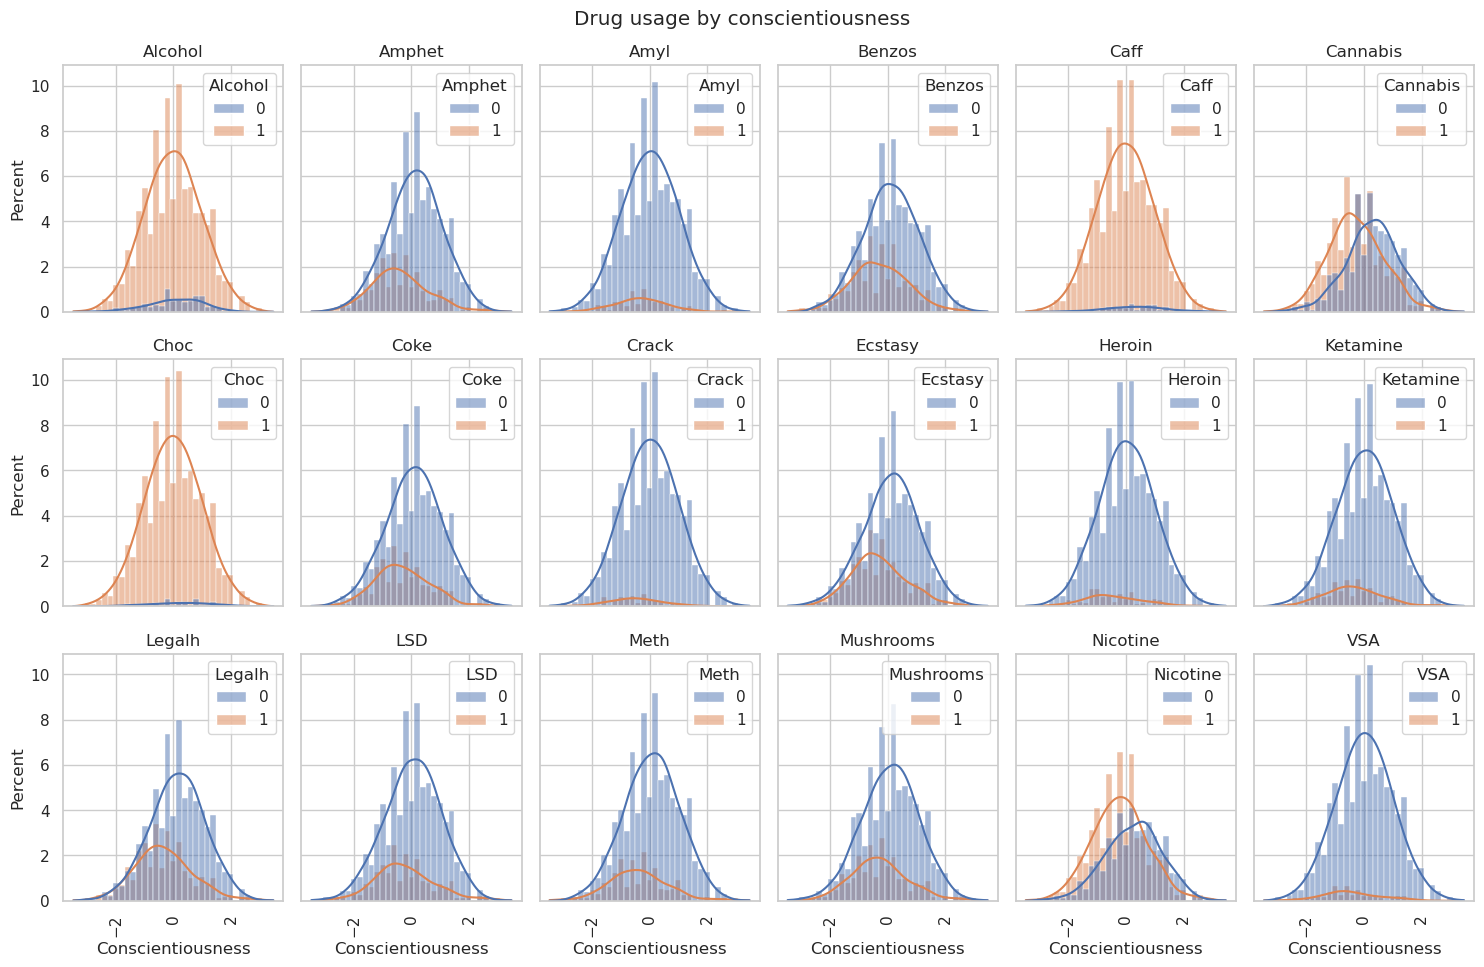

In [31]:
plot_drug_usage_num(df, 'Conscientiousness')

Podemos concluir o mesmo que a medida anterior, com destaque para **Cannabis** novamente.

### Impulsividade - "Impulsiveness"

Essa medida reflete a tendência de uma pessoa agir sem considerar as consequências, muitas vezes de forma repentina e sem planejamento. Pessoas impulsivas podem tomar decisões rápidas e às vezes arriscadas.

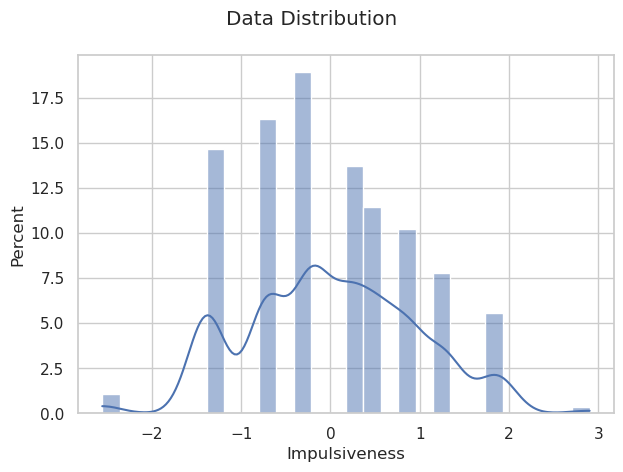

In [32]:
plot_distribution_num(df, 'Impulsiveness')

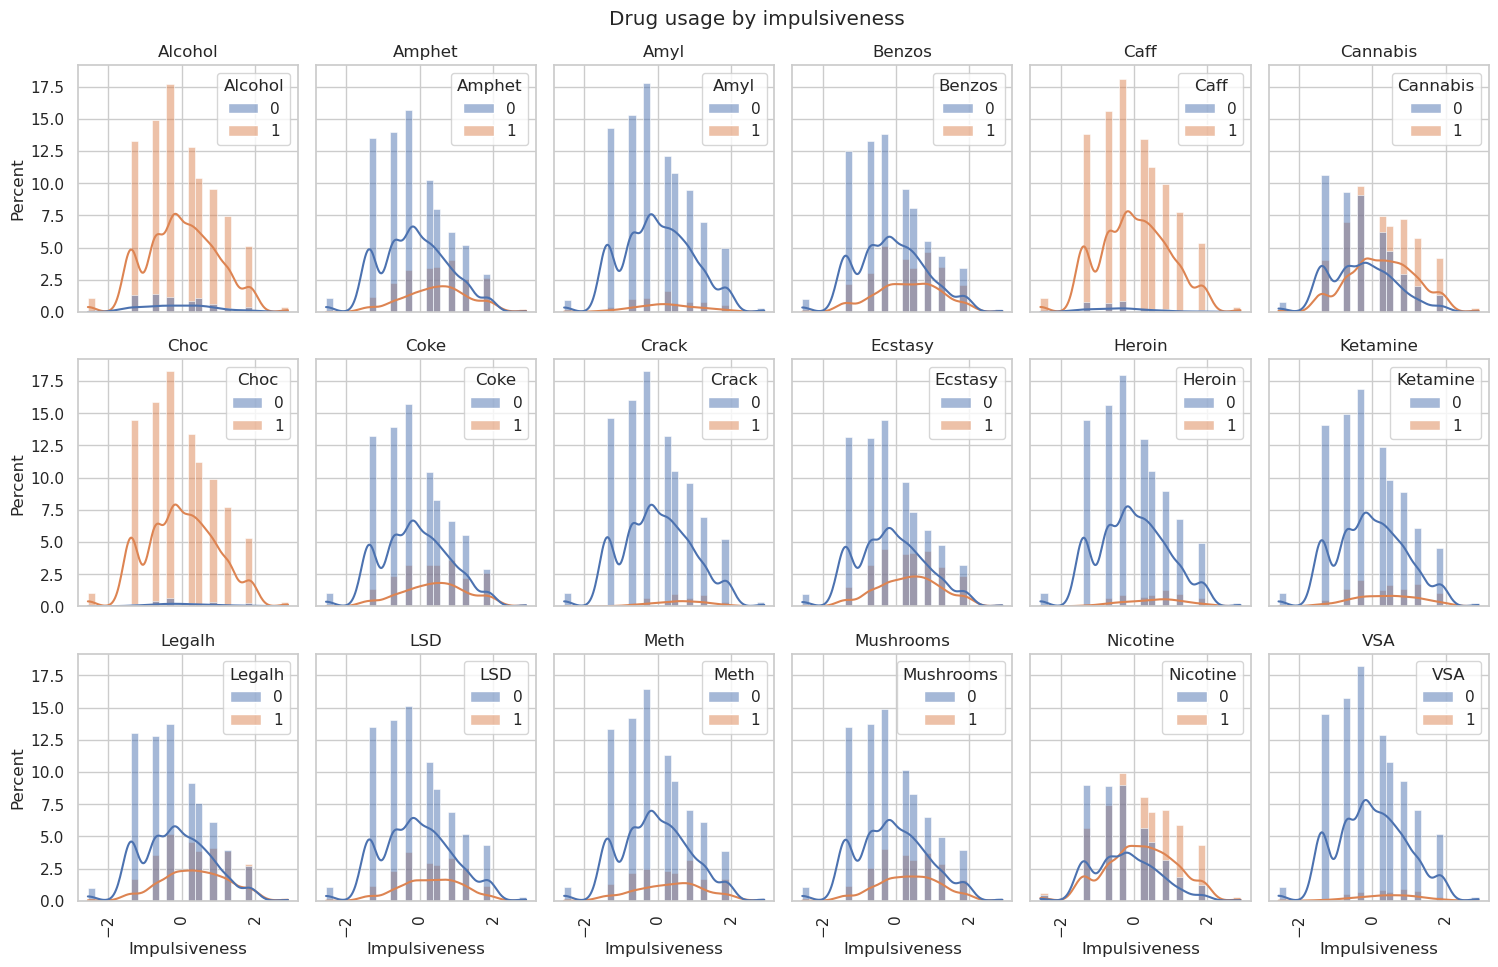

In [33]:
plot_drug_usage_num(df, 'Impulsiveness')

Devido a forma estranha dos dados, não é possível tirar conclusões muito claras.

### Busca de sensações - "Sensationness"

Essa medida indica o quanto uma pessoa busca experiências novas e emocionantes. Pessoas com alta busca de sensações tendem a buscar novidades, aventuras e sensações físicas e emocionais intensas.

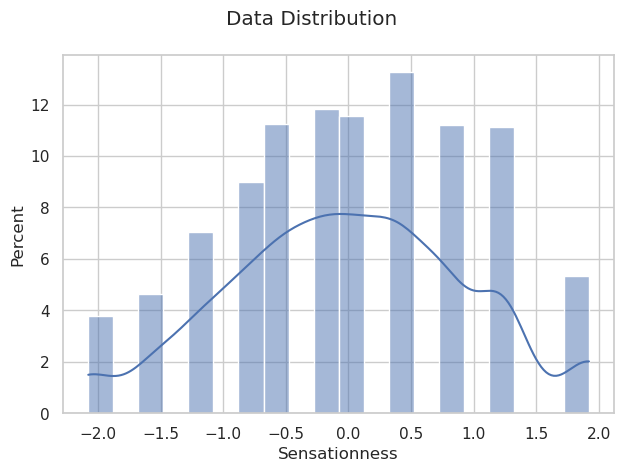

In [34]:
plot_distribution_num(df, 'Sensationness')

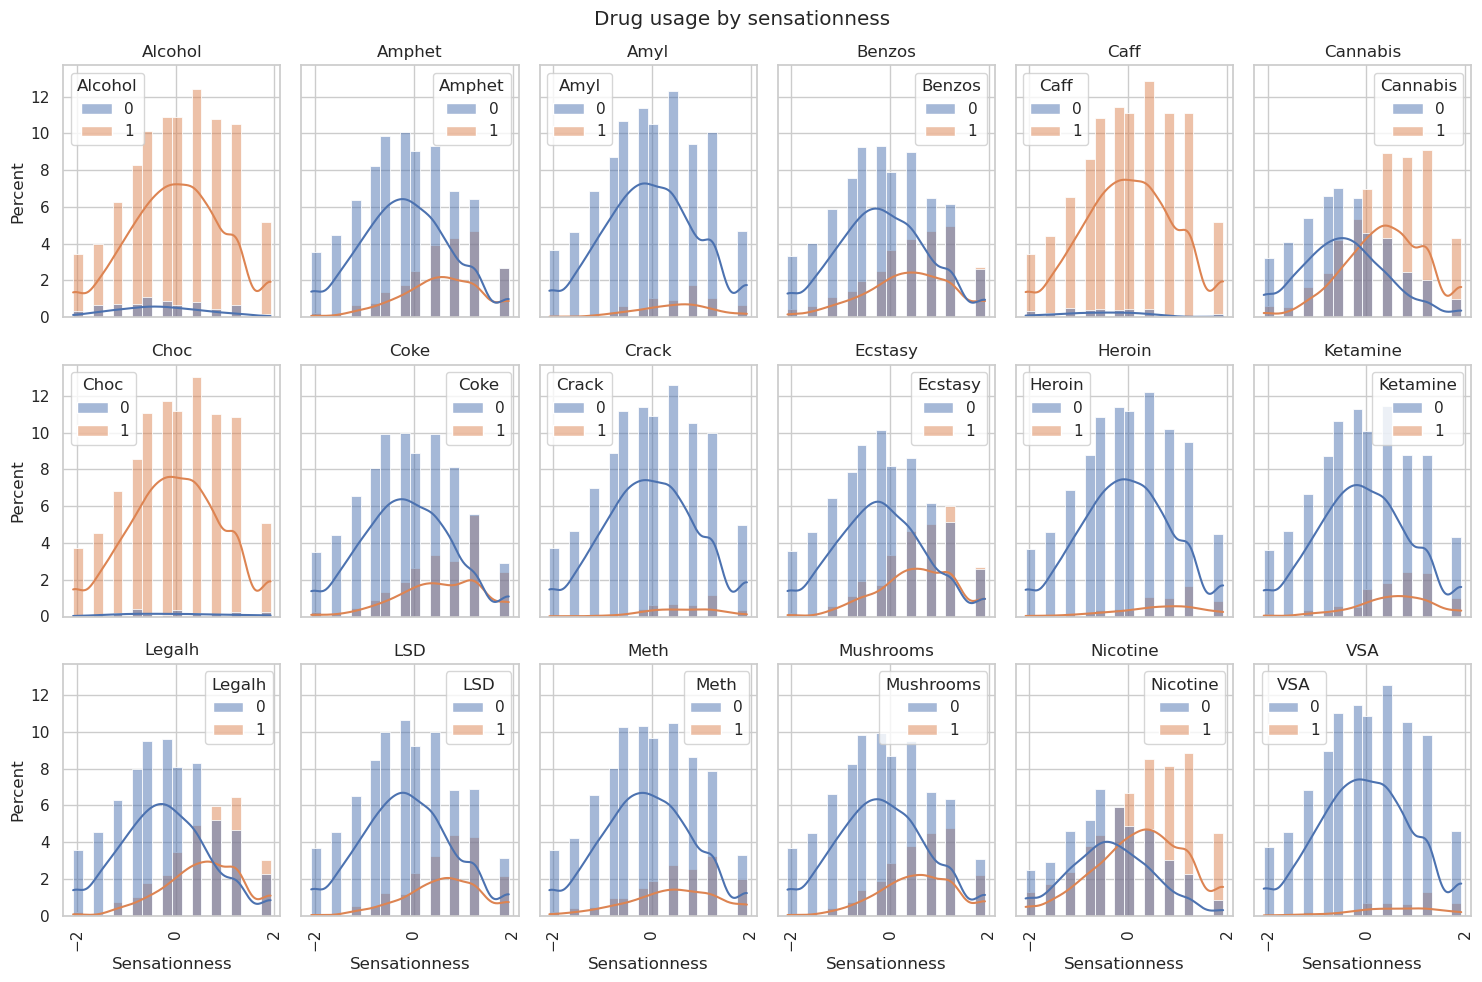

In [35]:
plot_drug_usage_num(df, 'Sensationness')

Aqui os dados também apresentaram uma forma estranha, mas vale destacar mais uma vez **Cannabis** apresentando uma separação considerável entre usuários e não usuários.

### Conclusões

Em algumas medidas não foi possível tirar conclusões claras, mas no geral, usuários de substâncias ilícitas apresentaram uma leve propensão a características consideradas negativas. Dito isso, pode ser que as medidas apresentadas acima auxiliem na classificação desses indivíduos como usuários.

## Transformação dos dados

In [36]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer(
    (OrdinalEncoder(dtype=int), ['Age']),
    (OneHotEncoder(drop='if_binary', sparse_output=False,
        dtype=int, feature_name_combiner=lambda x, y: x), ['Gender', 'Education']),
    verbose_feature_names_out=False,
    remainder="passthrough"
)
preprocessor.set_output(transform='pandas')

df[drug_columns] = original_labels
df = preprocessor.fit_transform(df)
df.to_csv("data/drug_consumption_preprocessed.csv")